In [1]:
import numpy as np
import pandas as pd
import pyreadr 
import networkx as nx
import re
from scipy import sparse
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap, pmap
from itertools import combinations
import importlib
import pyro
import torch
from tqdm import tqdm

# Autoreload magic commands
# %load_ext autoreload
# %autoreload 2

import src.Aux_functions as aux
import models_for_data_analysis as models
import utils_for_inference as util
import data_wrangle as dw
import wrapper_functions as wrap

# importlib.reload(aux)
# importlib.reload(util)
# importlib.reload(models_for_data_analysis)

# from models_for_data_analysis import noisy_networks_model


In [2]:
# Load data
all_schools = pyreadr.read_r('37070-0001-Data.rda')
all_schools = pd.DataFrame(all_schools['da37070.0001'])
all_schools

,SCHID,UID,SCHTREAT,SCHRB,ID,TREAT,STRB,SID1,SID3,SID4,...,AM_F,PI_M,PI_F,MU_M,MU_F,ROW_TOTAL,FREE_LUNCH,REDUCED_LUNCH,LEP,MIGRANT
0,1.0,100001.0,(1) Treatment school (Roots meetings 2012-2013),3,1,(0) Not treatment or control,0.0,5114,5114,5114,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
1,1.0,100002.0,(1) Treatment school (Roots meetings 2012-2013),3,2,(2) Control,4.0,5108,5108,5108,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
2,1.0,100003.0,(1) Treatment school (Roots meetings 2012-2013),3,3,(0) Not treatment or control,0.0,5100,5100,5100,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
3,1.0,100004.0,(1) Treatment school (Roots meetings 2012-2013),3,4,(0) Not treatment or control,0.0,5101,5101,5101,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
4,1.0,100005.0,(1) Treatment school (Roots meetings 2012-2013),3,5,(0) Not treatment or control,0.0,5087,5087,5087,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(029) 281-290,(008) 71-80,(005) 41-50,(001) 0-10,[MASKED BY ICPSR]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24466,60.0,6000670.0,(1) Treatment school (Roots meetings 2012-2013),11,670,NaN,NaN,13897,13897,13897,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]
24467,60.0,6000671.0,(1) Treatment school (Roots meetings 2012-2013),11,671,NaN,NaN,14054,14054,14054,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]
24468,60.0,6000672.0,(1) Treatment school (Roots meetings 2012-2013),11,672,NaN,NaN,13985,13985,13985,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]
24469,60.0,6000673.0,(1) Treatment school (Roots meetings 2012-2013),11,673,NaN,NaN,,,,...,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(001) 0-10,(071) 701-710,(004) 31-40,(002) 11-20,(001) 0-10,[MASKED BY ICPSR]


In [5]:
df_cleaned = dw.clean_data(all_schools)
print(df_cleaned.shape)
print(df_cleaned.describe())
print(df_cleaned.columns)

(24182, 39)
              SCHID  SCHTREAT_NUMERIC  TREAT_NUMERIC     unique_id  \
count  24182.000000      24182.000000   24182.000000  24182.000000   
mean      30.982260          0.493425       0.182532  31247.468448   
std       16.909763          0.499967       0.520467  16920.280101   
min        1.000000          0.000000       0.000000   1001.000000   
25%       19.000000          0.000000       0.000000  19005.250000   
50%       30.000000          0.000000       0.000000  30208.500000   
75%       45.000000          1.000000       0.000000  45207.750000   
max       60.000000          1.000000       2.000000  60674.000000   

           ELIGIBLE  WRISTOW2_NUMERIC           ST1           ST2  \
count  24182.000000      24182.000000  22639.000000  22474.000000   
mean       0.121702          0.076338    257.628959    260.186215   
std        0.326948          0.265543    188.955554    188.521128   
min        0.000000          0.000000      1.000000      1.000000   
25%        0

In [6]:
df_cleaned=df_cleaned[df_cleaned['SCHTREAT_NUMERIC']==1.0]

In [8]:
print(df_cleaned['ELIGIBLE'].unique(), df_cleaned['ELIGIBLE'].sum())

[0 1] 1456


In [16]:
print(df_cleaned['SCHID'].unique(), len(df_cleaned['SCHID'].unique()))

[ 1.  3.  6.  9. 10. 13. 19. 20. 21. 22. 24. 26. 27. 29. 31. 33. 34. 35.
 40. 42. 44. 45. 48. 49. 51. 56. 58. 60.] 28


In [19]:
print(df_cleaned['ELIGIBLE'].unique())

[0 1]


In [17]:
df_tst_school = df_cleaned[df_cleaned['SCHID']==1.0]
print(df_tst_school.shape, df_cleaned.shape, df_tst_school.columns)

(272, 39) (11932, 39) Index(['SCHID', 'SCHTREAT_NUMERIC', 'TREAT_NUMERIC', 'unique_id', 'ELIGIBLE',
       'WRISTOW2_NUMERIC', 'ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7',
       'ST8', 'ST9', 'ST10', 'ST1W2', 'ST2W2', 'ST3W2', 'ST4W2', 'ST5W2',
       'ST6W2', 'ST7W2', 'ST8W2', 'ST9W2', 'ST10W2', 'BF1', 'BF2', 'GENC',
       'ETHW', 'ETHB', 'ETHH', 'ETHA', 'ETHC', 'ETHSA', 'GAME', 'GRC_6',
       'GRC_7', 'GRC_8'],
      dtype='object')


In [9]:
df_cleaned['SCHID'].value_counts()

SCHID
24.0    835
56.0    708
22.0    683
60.0    661
58.0    613
20.0    586
34.0    555
51.0    547
19.0    502
6.0     464
42.0    439
21.0    436
45.0    426
49.0    409
9.0     393
31.0    387
33.0    382
35.0    370
10.0    319
48.0    316
13.0    288
29.0    285
27.0    285
1.0     272
44.0    271
26.0    203
40.0    159
3.0     138
Name: count, dtype: int64

(272, 272)
(3, 272, 272)


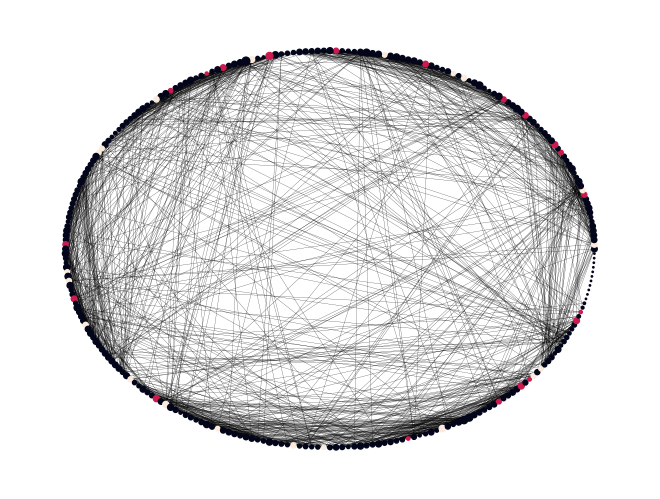

In [7]:
tst_network = dw.network_by_school(df_tst_school, dw.ST_COLS, True)
print(tst_network.shape)
tst_W2_network = dw.network_by_school(df_tst_school, dw.ST_W2_COLS, False)
tst_BF_network = dw.network_by_school(df_tst_school, dw.BF_COLS, False)
all_tst_nets = jnp.array([tst_network, tst_W2_network, tst_BF_network])
print(all_tst_nets.shape)

In [43]:
tst_cov_for_net = dw.create_net_covar_df(df_tst_school)
print(tst_cov_for_net.shape)
# print(tst_cov_for_net.describe())

torch.Size([36856, 4])


In [44]:
rng_key = random.PRNGKey(1)
rng_key, rng_key_ = random.split(rng_key)

net_svi_tst = util.Network_SVI(x_df = tst_cov_for_net, 
                                  # triu_obs = torch.tensor(adj_to_triu(tst_net),dtype=torch.float32))
                                  triu_obs = dw.adj_to_triu(tst_network),
                                  # triu_obs = torch.stack([tst_ST_triu, tst_BF_triu]),
                                  # network_model=models.multilayer_networks_model)
                                  network_model=models.one_noisy_networks_model,
                                  n_iter = 1000,
                                  n_samples = 1000)

net_svi_tst.train_model()

Training network model: 100%|██████████| 1000/1000 [00:25<00:00, 39.29it/s]


In [45]:
net_svi_samples = net_svi_tst.network_samples()
print(net_svi_samples.shape)

Sampling A*: 100%|██████████| 1000/1000 [00:22<00:00, 43.96it/s]


(1000, 36856)


In [65]:
tst_all_nets, tst_post_samples = wrap.one_school_network_analysis(df_tst_school)
print(tst_all_nets.shape, tst_post_samples.shape)

C:\Users\bar21\Dropbox\My PC (LAPTOP-6NAJD2IQ)\Desktop\Gate\University\TAU\PhD\Writing\Drafts\Sampled networks\Bayes_incorrect_network\Data\Palluck_et_al\data_wrangle.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] += df['SCHID'] * 1000
Sampling A*: 100%|██████████| 1000/1000 [00:29<00:00, 33.44it/s]


(3, 272, 272) (3, 1000, 36856)


In [46]:
# obs_zeigen_tst = util.zeigen_value(Z=net_svi_tst.trts, adj_mat=tst_network)
df_cleaned[df_cleaned['SCHID']==1.0]['TREAT_NUMERIC'].values

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [48]:
# Run outcome model
tst_obs_data = dw.data_for_outcome_regression(df_tst_school, tst_network)
print(tst_obs_data.keys())
print([a.shape for a in tst_obs_data.values()])
print([a.dtype for a in tst_obs_data.values()])

dict_keys(['X', 'school', 'grade', 'trts', 'sch_trts', 'exposures', 'Y'])
[(40, 4), (40,), (40,), (40,), (40,), (40,), (40,)]
[dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('float32'), dtype('int32')]


In [49]:
# Run outcome mcmc
rng_key = random.PRNGKey(0)
_, rng_key = random.split(rng_key)

outcome_obs = util.Outcome_MCMC(data=tst_obs_data, rng_key=rng_key)


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           eta[0]      0.71      1.13      0.70     -1.09      2.57   2945.02      1.00
           eta[1]     -1.43      1.23     -1.42     -3.46      0.59   5786.60      1.00
           eta[2]     -1.23      1.45     -1.14     -3.60      1.10   5227.23      1.00
           eta[3]      0.81      1.17      0.76     -1.09      2.78   6838.55      1.00
    eta_exposures      1.23      4.15      1.19     -5.36      8.02   1136.91      1.01
 eta_grade_std[0]      0.23      0.95      0.22     -1.21      1.89    904.20      1.01
 eta_grade_std[1]     -0.01      0.96     -0.04     -1.62      1.61    320.53      1.01
 eta_grade_std[2]     -0.13      0.93     -0.14     -1.62      1.45   8103.74      1.00
  eta_interaction      0.17      4.71      0.21     -7.64      7.72   2391.81      1.00
   eta_sch_std[0]      0.00      0.95      0.02     -1.55      1.64   7037.55      1.00
          eta_trt     -1.05    

In [60]:
# Run stochastic intervention
stoch_30 = util.stochastic_intervention(alpha=0.3, n=df_tst_school.shape[0])
exposures_stoch_30 = util.zeigen_value(Z=stoch_30, adj_mat=tst_network)
print(exposures_stoch_30.shape, stoch_30.shape)

# stoch_30_elig, exposur_30_elig = util.trt_and_exposures_of_elig(stoch_30, exposures_stoch_30, df_tst_school)
# print(stoch_30_elig.shape, exposur_30_elig.shape)


(100, 272) (100, 272)
(100, 40) (100, 40)


In [93]:
# ALPHAS = [0.3, 0.5, 0.7]
ALPHAS = [0.3, 0.7]

new_stoch_trts = []
new_stoch_obs_exposures = []
for i in range(len(ALPHAS)):
    new_stoch_trts.append(util.stochastic_intervention(alpha=ALPHAS[i], n=df_tst_school.shape[0]))
    new_stoch_obs_exposures.append(util.zeigen_value(Z=new_stoch_trts[i], adj_mat=tst_network))
    
new_stoch_trts = jnp.stack(new_stoch_trts)
print(new_stoch_trts.shape)
new_stoch_obs_exposures = jnp.stack(new_stoch_obs_exposures)
print(new_stoch_obs_exposures.shape)

print(jnp.stack([new_stoch_trts, new_stoch_obs_exposures]).shape)

stoch_trt_elig, stoch_exposures_elig = util.trt_and_exposures_of_elig(new_stoch_trts,
                                                                      new_stoch_obs_exposures,
                                                                      df_tst_school)
print(stoch_trt_elig.shape, stoch_exposures_elig.shape)

print(jnp.stack([stoch_trt_elig, stoch_exposures_elig]).shape)

(2, 100, 272)
(2, 100, 272)
(2, 2, 100, 272)
(2, 100, 40) (2, 100, 40)
(2, 2, 100, 40)


In [94]:
all_trt_expos, elig_trt_expos = wrap.get_stoch_treatments_and_obs_exposures(df_tst_school, tst_network)
print(all_trt_expos.shape, elig_trt_expos.shape)

(2, 2, 100, 272) (2, 2, 100, 40)


In [97]:
post_obs_exposure = util.vectorized_post_exposures(net_svi_samples,
                                                   jnp.array(df_tst_school['TREAT_NUMERIC'].values),
                                                   df_tst_school.shape[0])
print(post_obs_exposure.shape)
post_obs_expos_elig = post_obs_exposure[:,(df_tst_school['ELIGIBLE']==1).values]
print(post_obs_expos_elig.shape)

(1000, 272)
(1000, 40)


In [96]:
# testing posterior exposures for all net models 
post_stoch_expos = wrap.posterior_stoch_exposures(tst_post_samples, all_trt_expos, df_tst_school)
print(post_stoch_expos.shape)

(3, 2, 1000, 100, 40)


In [145]:
# Wrapper for one school 
cur_schid = 1.0
# get df
cur_df = df_cleaned[df_cleaned['SCHID']==cur_schid]
# run network analysis
print("Network analysis")
cur_all_nets, cur_post_samples = wrap.one_school_network_analysis(cur_df)
print(cur_all_nets.shape, cur_post_samples.shape)
# get stochastic interventions
print("Stochastic interventions")
cur_all_trt_expos, cur_elig_trt_expos = wrap.get_stoch_treatments_and_obs_exposures(cur_df, cur_all_nets[0])
# Get posterior exposures for observed treatments for each network model
print("Posterior exposures for observed treatments")
cur_post_obs_exposure = wrap.posterior_exposure_for_obs_treatments(cur_post_samples, jnp.array(cur_df['TREAT_NUMERIC'].values), cur_df)
print(cur_post_obs_exposure.shape)
# Posterior exposures for stochastic interventions
print("Posterior exposures for stochastic interventions")
cur_post_stoch_expos = wrap.posterior_stoch_exposures(cur_post_samples, cur_all_trt_expos, cur_df)
print(cur_post_stoch_expos.shape)
# Observed data for outcome reg
print("Observed data for outcome regression")
cur_obs_data = dw.data_for_outcome_regression(cur_df, cur_all_nets[0])
print(cur_obs_data.keys())
print([a.shape for a in cur_obs_data.values()])
print([a.dtype for a in cur_obs_data.values()])


Network analysis


Sampling A*: 100%|██████████| 1000/1000 [00:37<00:00, 26.58it/s]


(3, 272, 272) (3, 1000, 36856)
Stochastic interventions
Posterior exposures for observed treatments
(3, 1000, 40)
Posterior exposures for stochastic interventions
(3, 2, 1000, 100, 40)
Observed data for outcome regression
dict_keys(['X', 'school', 'grade', 'trts', 'sch_trts', 'exposures', 'Y'])
[(40, 4), (40,), (40,), (40,), (40,), (40,), (40,)]
[dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('float32'), dtype('int32')]


In [148]:
# Test wrapper for one school
tst_data, tst_stoch_trt_expos, tst_post_obs_expos, tst_post_stoch_expos = wrap.one_school_iteration(df_cleaned, 1.0)

print(tst_data.keys())
print([a.shape for a in tst_data.values()])
print([a.dtype for a in tst_data.values()]) 
print(tst_stoch_trt_expos.shape)
print(tst_post_obs_expos.shape)
print(tst_post_stoch_expos.shape)


Sampling A*: 100%|██████████| 1000/1000 [00:35<00:00, 28.09it/s]


dict_keys(['X', 'school', 'grade', 'trts', 'sch_trts', 'exposures', 'Y'])
[(40, 4), (40,), (40,), (40,), (40,), (40,), (40,)]
[dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('float32'), dtype('int32')]
(2, 2, 100, 40)
(3, 1000, 40)
(3, 2, 1000, 100, 40)


In [153]:
tst_data2, tst_stoch_trt_expos2, tst_post_obs_expos2, tst_post_stoch_expos2 = wrap.one_school_iteration(df_cleaned, 5.0)

print(tst_data2.keys())
print([a.shape for a in tst_data2.values()])
print([a.dtype for a in tst_data2.values()])
print(tst_stoch_trt_expos2.shape)
print(tst_post_obs_expos2.shape)
print(tst_post_stoch_expos2.shape)


Sampling A*: 100%|██████████| 1000/1000 [00:20<00:00, 48.95it/s]


dict_keys(['X', 'school', 'grade', 'trts', 'sch_trts', 'exposures', 'Y'])
[(40, 4), (40,), (40,), (40,), (40,), (40,), (40,)]
[dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('float32'), dtype('int32')]
(2, 2, 100, 40)
(3, 1000, 40)
(3, 2, 1000, 100, 40)


In [155]:
print(jnp.concatenate([tst_post_obs_expos,tst_post_obs_expos2], axis=-1).shape)
print(jnp.concatenate([tst_post_stoch_expos,tst_post_stoch_expos2], axis=-1).shape)

(3, 1000, 80)
(3, 2, 1000, 100, 80)


In [157]:
tst_both_obs_data = dw.concatenate_dict_arrays([tst_data, tst_data2])
print(tst_both_obs_data.keys())
print([a.shape for a in tst_both_obs_data.values()])
print([a.dtype for a in tst_both_obs_data.values()])


dict_keys(['X', 'school', 'grade', 'trts', 'sch_trts', 'exposures', 'Y'])
[(80, 4), (80,), (80,), (80,), (80,), (80,), (80,)]
[dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('float32'), dtype('int32')]


In [8]:
all_data, all_stoch_trt_expos, all_post_obs_expos, all_post_stoch_expos = wrap.all_schools_network_run_and_posterior(df_cleaned[df_cleaned['SCHID'].isin([1.0,3.0,6.0])])

print(all_data.keys())
print([a.shape for a in all_data.values()])
print([a.dtype for a in all_data.values()])
print(all_stoch_trt_expos.shape)
print(all_post_obs_expos.shape)
print(all_post_stoch_expos.shape)

print(df_cleaned[df_cleaned['SCHID'].isin([1.0,3.0,6.0])]['ELIGIBLE'].sum())


running for schid:  1.0


Sampling A*: 100%|██████████| 500/500 [00:15<00:00, 31.32it/s]


running for schid:  3.0


Sampling A*: 100%|██████████| 500/500 [00:10<00:00, 47.82it/s]


running for schid:  6.0


Sampling A*: 100%|██████████| 500/500 [00:33<00:00, 14.74it/s]


dict_keys(['X', 'school', 'grade', 'trts', 'sch_trts', 'exposures', 'Y'])
[(136, 4), (136,), (136,), (136,), (136,), (136,), (136,)]
[dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('int32'), dtype('float32'), dtype('int32')]
(2, 2, 100, 136)
(3, 500, 136)
(3, 2, 500, 100, 136)
136


In [89]:
print(all_post_stoch_expos[0][:,0:55].shape,
        all_post_stoch_expos[0][:,0].shape)

(2, 55, 100, 136) (2, 100, 136)


In [9]:
all_data['school']

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6], dtype=int32)

In [10]:

print(all_data['school'])
print(dw.transform_schid(all_data['school']))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [11]:
all_data['school'] = dw.transform_schid(all_data['school'])
# remove the '+1' next time since I updated the original code

(array([49., 17., 14.,  4.,  8.,  4.,  6.,  6.,  5.,  3.,  7.,  1.,  2.,
         0.,  3.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.        , 0.02403366, 0.04806732, 0.07210098, 0.09613465,
        0.12016831, 0.14420196, 0.16823563, 0.1922693 , 0.21630296,
        0.24033661, 0.26437029, 0.28840393, 0.31243759, 0.33647126,
        0.36050493, 0.38453859, 0.40857226, 0.43260592, 0.45663956,
        0.48067322, 0.50470692, 0.52874058, 0.55277419, 0.57680786,
        0.60084152, 0.62487519, 0.64890885, 0.67294252, 0.69697618,
        0.72100985]),
 <BarContainer object of 30 artists>)

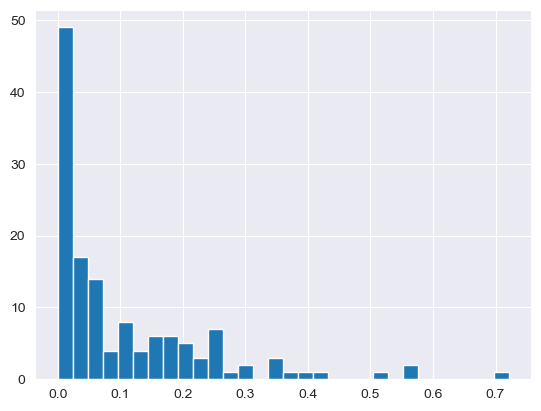

In [13]:
plt.hist(all_data['exposures'], bins=30)

In [57]:
rng_key = random.PRNGKey(0)
_, rng_key = random.split(rng_key)

tst_outcome_obs = util.Outcome_MCMC(data=all_data, rng_key=rng_key)


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           eta[0]     -0.38      0.52     -0.38     -1.22      0.47   7943.14      1.00
           eta[1]     -0.88      0.55     -0.89     -1.84     -0.03   8885.18      1.00
           eta[2]     -0.52      0.73     -0.50     -1.66      0.74   8173.33      1.00
           eta[3]      0.20      0.54      0.20     -0.67      1.11   8096.98      1.00
    eta_exposures     -0.30      2.15     -0.27     -3.80      3.28   7299.15      1.00
 eta_grade_std[0]      0.20      0.93      0.21     -1.29      1.72   9078.01      1.00
 eta_grade_std[1]     -0.06      0.91     -0.06     -1.57      1.41   8659.99      1.00
 eta_grade_std[2]     -0.15      0.89     -0.17     -1.64      1.32   8631.66      1.00
  eta_interaction     -0.55      2.77     -0.50     -5.12      4.02   6452.92      1.00
   eta_sch_std[0]      0.12      0.87      0.12     -1.30      1.51   8185.24      1.00
   eta_sch_std[1]      0.39    

In [140]:
print(all_stoch_trt_expos.shape)
print(all_stoch_trt_expos[0].shape)
print(all_stoch_trt_expos[1].shape)
print(all_stoch_trt_expos[0][0].shape)

(2, 2, 100, 136)
(2, 100, 136)
(2, 100, 136)
(100, 136)


[autoreload of wrapper_functions failed: Traceback (most recent call last):
  File "C:\Users\bar21\.conda\envs\STAT\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
    
  File "C:\Users\bar21\.conda\envs\STAT\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
    
  File "C:\Users\bar21\.conda\envs\STAT\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
    
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "C:\Users\bar21\Dropbox\My PC (LAPTOP-6NAJD2IQ)\Desktop\Gate\University\TAU\PhD\Writing\Drafts\Sampled networks\Ba

In [59]:
tst_stoch_pred = tst_outcome_obs.get_predicted_values(trts=all_stoch_trt_expos[0],
                                                      exposures=all_stoch_trt_expos[1])

print(tst_stoch_pred.shape)


(2, 10000, 136)


In [142]:
tst_obs_network_outcome_model = wrap.observed_network_run(all_data, all_stoch_trt_expos, rng_key)
print(tst_obs_network_outcome_model)

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           eta[0]     -0.38      0.52     -0.38     -1.22      0.47   7943.14      1.00
           eta[1]     -0.88      0.55     -0.89     -1.84     -0.03   8885.18      1.00
           eta[2]     -0.52      0.73     -0.50     -1.66      0.74   8173.33      1.00
           eta[3]      0.20      0.54      0.20     -0.67      1.11   8096.98      1.00
    eta_exposures     -0.30      2.15     -0.27     -3.80      3.28   7299.15      1.00
 eta_grade_std[0]      0.20      0.93      0.21     -1.29      1.72   9078.01      1.00
 eta_grade_std[1]     -0.06      0.91     -0.06     -1.57      1.41   8659.99      1.00
 eta_grade_std[2]     -0.15      0.89     -0.17     -1.64      1.32   8631.66      1.00
  eta_interaction     -0.55      2.77     -0.50     -5.12      4.02   6452.92      1.00
   eta_sch_std[0]      0.12      0.87      0.12     -1.30      1.51   8185.24      1.00
   eta_sch_std[1]      0.39    

In [60]:
# Plot mean (95% CI) for each stoch prediction
esti_stoch_pred = jnp.mean(tst_stoch_pred, axis=2)
print(esti_stoch_pred.shape)
mean_esti_pred = jnp.mean(esti_stoch_pred, axis=1)
print(mean_esti_pred.shape)
quantiles_esti_pred = jnp.quantile(esti_stoch_pred, q=jnp.array([0.025, 0.975]), axis=1)
print(quantiles_esti_pred.shape)
# quantiles_stoch_pred = jnp.quantile(tst_stoch_pred, q=jnp.array([0.025, 0.975]), axis=1)
# print(mean_stoch_pred.shape)
# print(quantiles_stoch_pred.shape)

# plot point estimate and 95% CI for each of 3 stoch trts
# 
# plt.figure(figsize=(8, 6))
# plt.errorbar(x=jnp.arange(mean_stoch_pred.shape[0]), y=mean_stoch_pred, yerr=[mean_stoch_pred - quantiles_stoch_pred[0], quantiles_stoch_pred[1] - mean_stoch_pred], fmt='o')
# plt.xlabel("Stoch pred")
# plt.ylabel("Predicted estimand")


(2, 10000)
(2,)
(2, 2)


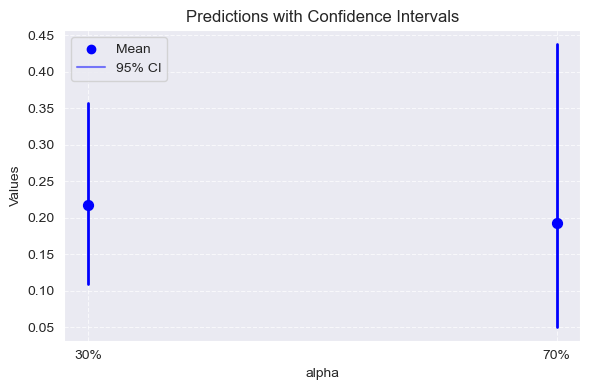

In [73]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# X-coordinates for the three variables
x = np.arange(2)
# x = [0.25,0.75]

# Plot the mean points
ax.scatter(x, mean_esti_pred, color='blue', s=50, zorder=2)

# Plot the confidence intervals
for i in range(2):
    ax.plot([i, i], quantiles_esti_pred[:, i], color='blue', linewidth=2, zorder=2)

# Customize the plot
ax.set_xlabel('alpha')
ax.set_ylabel('Values')
ax.set_title('Predictions with Confidence Intervals')
ax.set_xticks(x)
ax.set_xticklabels(['30%', '70%'])
ax.grid(True, linestyle='--', alpha=0.7)

# Add legend
ax.scatter([], [], color='blue', label='Mean')
ax.plot([], [], color='blue', label='95% CI', alpha=0.5)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# TODO: test with onestage inferece
# TODO: test with multistage inferenec
# TODO: In multistage, need to think how to combine the estimation (with posterior obs exposures), and predictions of stoch treatments in one run. 
# TODO: check prediction in outcome model  above

In [39]:
print(all_data.keys())

dict_keys(['X', 'school', 'grade', 'trts', 'sch_trts', 'exposures', 'Y'])


In [38]:
all_post_obs_expos[0].mean(axis=0).shape

(136,)

In [76]:
# onestage inference 

tst_onestage_one_noisy_net = util.Onestage_MCMC(obs_trts=all_data['trts'],
                                                post_exposures= all_post_obs_expos[0].mean(axis=0),
                                                sch_trts = all_data['sch_trts'],
                                                fixed_df=all_data['X'],
                                                grade = all_data['grade'],
                                                school = all_data['school'],
                                                Y = all_data['Y'],
                                                rng_key=rng_key)

tst_onestage_repeated_noisy = util.Onestage_MCMC(obs_trts=all_data['trts'],
                                                post_exposures= all_post_obs_expos[1].mean(axis=0),
                                                sch_trts = all_data['sch_trts'],
                                                fixed_df=all_data['X'],
                                                grade = all_data['grade'],
                                                school = all_data['school'],
                                                Y = all_data['Y'],
                                                rng_key=rng_key)

tst_onestage_multilayer = util.Onestage_MCMC(obs_trts=all_data['trts'],
                                                post_exposures= all_post_obs_expos[2].mean(axis=0),
                                                sch_trts = all_data['sch_trts'],
                                                fixed_df=all_data['X'],
                                                grade = all_data['grade'],
                                                school = all_data['school'],
                                                Y = all_data['Y'],
                                                rng_key=rng_key)




  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           eta[0]     -0.34      0.52     -0.34     -1.21      0.48   8876.45      1.00
           eta[1]     -0.89      0.56     -0.89     -1.84     -0.01  10261.93      1.00
           eta[2]     -0.51      0.72     -0.49     -1.70      0.65  10119.93      1.00
           eta[3]      0.20      0.55      0.19     -0.70      1.08   9760.91      1.00
    eta_exposures     -0.11      0.43     -0.13     -0.84      0.53   5499.69      1.00
 eta_grade_std[0]      0.20      0.93      0.20     -1.31      1.72  11065.77      1.00
 eta_grade_std[1]     -0.04      0.89     -0.05     -1.50      1.41  10716.20      1.00
 eta_grade_std[2]     -0.13      0.89     -0.14     -1.61      1.32   9870.50      1.00
  eta_interaction      0.19      0.42      0.19     -0.48      0.91   6629.02      1.00
   eta_sch_std[0]      0.06      0.94      0.06     -1.52      1.56   9181.61      1.00
   eta_sch_std[1]      0.35    

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           eta[0]     -0.32      0.52     -0.32     -1.16      0.55  10887.07      1.00
           eta[1]     -0.94      0.59     -0.93     -1.96     -0.01   7434.61      1.00
           eta[2]     -0.69      0.75     -0.67     -1.91      0.53   8555.22      1.00
           eta[3]     -0.02      0.57     -0.03     -0.89      0.98   8842.44      1.00
    eta_exposures     -0.87      0.78     -0.70     -2.14      0.22   2721.39      1.00
 eta_grade_std[0]      0.29      0.94      0.31     -1.18      1.89   9893.46      1.00
 eta_grade_std[1]     -0.06      0.89     -0.07     -1.44      1.47  11673.14      1.00
 eta_grade_std[2]     -0.20      0.89     -0.21     -1.68      1.26  10274.56      1.00
  eta_interaction     -0.32      0.52     -0.32     -1.11      0.60   5819.42      1.00
   eta_sch_std[0]      0.66      0.89      0.69     -0.79      2.09   8106.07      1.00
   eta_sch_std[1]     -0.38    

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           eta[0]     -0.34      0.51     -0.33     -1.15      0.49   9305.43      1.00
           eta[1]     -0.70      0.57     -0.71     -1.67      0.21  10704.91      1.00
           eta[2]     -0.52      0.71     -0.49     -1.64      0.66   9799.15      1.00
           eta[3]      0.07      0.56      0.07     -0.83      1.00   9320.15      1.00
    eta_exposures     -0.29      0.44     -0.25     -0.86      0.34   2165.04      1.00
 eta_grade_std[0]      0.27      0.93      0.29     -1.34      1.69  10805.59      1.00
 eta_grade_std[1]     -0.06      0.89     -0.07     -1.51      1.42   9628.90      1.00
 eta_grade_std[2]     -0.20      0.89     -0.22     -1.65      1.28   9768.51      1.00
  eta_interaction     -0.07      0.33     -0.07     -0.60      0.46   7227.09      1.00
   eta_sch_std[0]      0.31      0.89      0.31     -1.15      1.76   9078.83      1.00
   eta_sch_std[1]     -0.09    

In [132]:
print(all_stoch_trt_expos.shape)
print(all_post_stoch_expos.shape)
print(all_post_stoch_expos[0].shape)
print(all_post_stoch_expos[0].mean(axis=1).shape)
print(all_post_stoch_expos[1].mean(axis=1).shape)

(2, 2, 100, 136)
(3, 2, 500, 100, 136)
(2, 500, 100, 136)
(2, 100, 136)
(2, 100, 136)


In [80]:
# get predictions for onestage models 

tst_onestage_one_noisy_net_pred = tst_onestage_one_noisy_net.get_predicted_values(trts=all_stoch_trt_expos[0],
                                                                                  exposures = all_post_stoch_expos[0].mean(axis=1))

tst_onestage_repeated_pred = tst_onestage_repeated_noisy.get_predicted_values(trts=all_stoch_trt_expos[0],
                                                                                exposures = all_post_stoch_expos[1].mean(axis=1))

tst_onestage_multilayer_pred = tst_onestage_multilayer.get_predicted_values(trts=all_stoch_trt_expos[0],
                                                                            exposures = all_post_stoch_expos[2].mean(axis=1))

print(tst_onestage_one_noisy_net_pred.shape,
      tst_onestage_repeated_pred.shape,
      tst_onestage_multilayer_pred.shape)


(2, 10000, 136) (2, 10000, 136) (2, 10000, 136)


In [81]:
# save mean [95% ci] for each model 
os_one_noisy_esti_pred = jnp.mean(tst_onestage_one_noisy_net_pred, axis=2)
print(os_one_noisy_esti_pred.shape)
os_one_noisy_mean_esti= jnp.mean(os_one_noisy_esti_pred, axis=1)
print(os_one_noisy_mean_esti.shape)
os_one_noisy_quantiles_esti = jnp.quantile(os_one_noisy_esti_pred, q=jnp.array([0.025, 0.975]), axis=1)
print(os_one_noisy_quantiles_esti.shape)

os_repeated_esti_pred = jnp.mean(tst_onestage_repeated_pred, axis=2)
print(os_repeated_esti_pred.shape)
os_repeated_mean_esti= jnp.mean(os_repeated_esti_pred, axis=1)
print(os_repeated_mean_esti.shape)
os_repeated_quantiles_esti = jnp.quantile(os_repeated_esti_pred, q=jnp.array([0.025, 0.975]), axis=1)
print(os_repeated_quantiles_esti.shape)

os_multilayer_esti_pred = jnp.mean(tst_onestage_multilayer_pred, axis=2)
print(os_multilayer_esti_pred.shape)
os_multilayer_mean_esti= jnp.mean(os_multilayer_esti_pred, axis=1)
print(os_multilayer_mean_esti.shape)
os_multilayer_quantiles_esti = jnp.quantile(os_multilayer_esti_pred, q=jnp.array([0.025, 0.975]), axis=1)
print(os_multilayer_quantiles_esti.shape)

combined_os_mean_pred = jnp.stack([os_one_noisy_mean_esti, os_repeated_mean_esti, os_multilayer_mean_esti])
combined_os_quantiles_pred = jnp.stack([os_one_noisy_quantiles_esti, os_repeated_quantiles_esti, os_multilayer_quantiles_esti])
print(combined_os_mean_pred.shape, combined_os_quantiles_pred.shape)

(2, 10000)
(2,)
(2, 2)
(2, 10000)
(2,)
(2, 2)
(2, 10000)
(2,)
(2, 2)
(3, 2) (3, 2, 2)


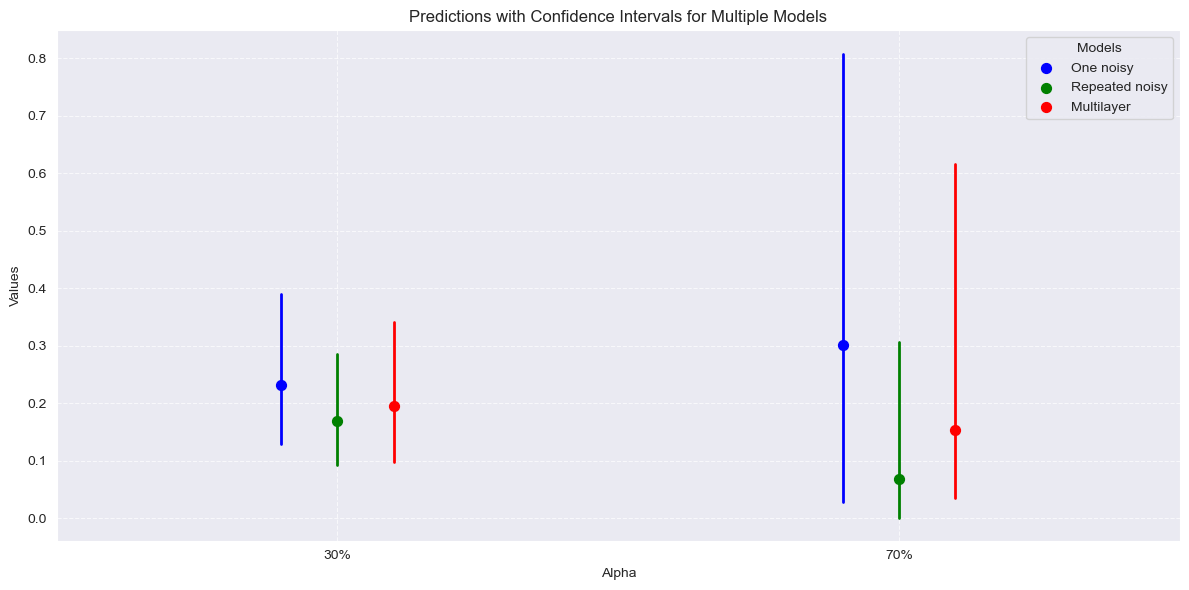

In [83]:
fig, ax = plt.subplots(figsize=(12, 6))

# X-coordinates for the three variables
x = np.arange(2)
width = 0.1  # Width of each bar

# Colors for each model
colors = ['blue', 'green', 'red']
model_names = ['One noisy', 'Repeated noisy', 'Multilayer']

# Plot for each model
for i in range(3):
    # Plot the mean points
    ax.scatter(x + (i - 1) * width, combined_os_mean_pred[i], color=colors[i], s=50, zorder=3, label=model_names[i])
    
    # Plot the confidence intervals
    for j in range(2):
        ax.plot([x[j] + (i - 1) * width, x[j] + (i - 1) * width], 
                combined_os_quantiles_pred[i, :, j], color=colors[i], linewidth=2, zorder=2)

# Customize the plot
ax.set_xlabel('Alpha')
ax.set_ylabel('Values')
ax.set_title('Predictions with Confidence Intervals for Multiple Models')
ax.set_xticks(x)
ax.set_xticklabels(['30%', '70%'])
ax.grid(True, linestyle='--', alpha=0.7)

# Add legend
ax.legend(title='Models')

# Adjust x-axis limits for better spacing
ax.set_xlim(-0.5, len(x) - 0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [134]:
# one stage complete

onestage_results = wrap.onestage_run(all_data, 
                                     all_stoch_trt_expos,
                                     all_post_obs_expos,
                                     all_post_stoch_expos,
                                     rng_key)
print(onestage_results)

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           eta[0]     -0.34      0.52     -0.34     -1.21      0.48   8876.45      1.00
           eta[1]     -0.89      0.56     -0.89     -1.84     -0.01  10261.93      1.00
           eta[2]     -0.51      0.72     -0.49     -1.70      0.65  10119.93      1.00
           eta[3]      0.20      0.55      0.19     -0.70      1.08   9760.91      1.00
    eta_exposures     -0.11      0.43     -0.13     -0.84      0.53   5499.69      1.00
 eta_grade_std[0]      0.20      0.93      0.20     -1.31      1.72  11065.77      1.00
 eta_grade_std[1]     -0.04      0.89     -0.05     -1.50      1.41  10716.20      1.00
 eta_grade_std[2]     -0.13      0.89     -0.14     -1.61      1.32   9870.50      1.00
  eta_interaction      0.19      0.42      0.19     -0.48      0.91   6629.02      1.00
   eta_sch_std[0]      0.06      0.94      0.06     -1.52      1.56   9181.61      1.00
   eta_sch_std[1]      0.35    

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           eta[0]     -0.32      0.52     -0.32     -1.16      0.55  10887.07      1.00
           eta[1]     -0.94      0.59     -0.93     -1.96     -0.01   7434.61      1.00
           eta[2]     -0.69      0.75     -0.67     -1.91      0.53   8555.22      1.00
           eta[3]     -0.02      0.57     -0.03     -0.89      0.98   8842.44      1.00
    eta_exposures     -0.87      0.78     -0.70     -2.14      0.22   2721.39      1.00
 eta_grade_std[0]      0.29      0.94      0.31     -1.18      1.89   9893.46      1.00
 eta_grade_std[1]     -0.06      0.89     -0.07     -1.44      1.47  11673.14      1.00
 eta_grade_std[2]     -0.20      0.89     -0.21     -1.68      1.26  10274.56      1.00
  eta_interaction     -0.32      0.52     -0.32     -1.11      0.60   5819.42      1.00
   eta_sch_std[0]      0.66      0.89      0.69     -0.79      2.09   8106.07      1.00
   eta_sch_std[1]     -0.38    

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           eta[0]     -0.34      0.51     -0.33     -1.15      0.49   9305.43      1.00
           eta[1]     -0.70      0.57     -0.71     -1.67      0.21  10704.91      1.00
           eta[2]     -0.52      0.71     -0.49     -1.64      0.66   9799.15      1.00
           eta[3]      0.07      0.56      0.07     -0.83      1.00   9320.15      1.00
    eta_exposures     -0.29      0.44     -0.25     -0.86      0.34   2165.04      1.00
 eta_grade_std[0]      0.27      0.93      0.29     -1.34      1.69  10805.59      1.00
 eta_grade_std[1]     -0.06      0.89     -0.07     -1.51      1.42   9628.90      1.00
 eta_grade_std[2]     -0.20      0.89     -0.22     -1.65      1.28   9768.51      1.00
  eta_interaction     -0.07      0.33     -0.07     -0.60      0.46   7227.09      1.00
   eta_sch_std[0]      0.31      0.89      0.31     -1.15      1.76   9078.83      1.00
   eta_sch_std[1]     -0.09    

In [108]:
print(all_post_obs_expos.shape)
print(all_post_obs_expos[0][0:8].shape)
print(all_post_stoch_expos[0][:,0:8].shape)
print(all_stoch_trt_expos[0].shape)
print(all_post_stoch_expos.shape)

reshaped_post_stoch_expos = jnp.transpose(all_post_stoch_expos, axes=(0,2,1,3,4))
print(reshaped_post_stoch_expos.shape)
print(reshaped_post_stoch_expos[0].shape)
print(reshaped_post_stoch_expos[0][0:8].shape)

(3, 500, 136)
(8, 136)
(2, 8, 100, 136)
(2, 100, 136)
(3, 2, 500, 100, 136)
(3, 500, 2, 100, 136)
(500, 2, 100, 136)
(8, 2, 100, 136)


In [136]:
i_range = np.random.choice(a=range(all_post_obs_expos.shape[1]),
                           size=88,
                           replace=False)

print(all_post_obs_expos[0][i_range].shape)
print(reshaped_post_stoch_expos[0][i_range].shape)


(88, 136)
(88, 2, 100, 136)


In [109]:
# multistage inference

ms_one_noisy_net = util.linear_multistage(post_exposures = all_post_obs_expos[0],
                                          post_new_exposures = reshaped_post_stoch_expos[0],
                                          obs_trts = all_data['trts'],
                                          new_trts = all_stoch_trt_expos[0],
                                          sch_trts = all_data['sch_trts'],
                                          fixed_df = all_data['X'],
                                          grade = all_data['grade'],
                                          school = all_data['school'],
                                          Y = all_data['Y'],
                                          key=rng_key)
print(ms_one_noisy_net.shape)

ms_repeated_noisy_net = util.linear_multistage(post_exposures = all_post_obs_expos[1],
                                            post_new_exposures = reshaped_post_stoch_expos[1],
                                            obs_trts = all_data['trts'],
                                            new_trts = all_stoch_trt_expos[0],
                                            sch_trts = all_data['sch_trts'],
                                            fixed_df = all_data['X'],
                                            grade = all_data['grade'],
                                            school = all_data['school'],
                                            Y = all_data['Y'],
                                            key=rng_key)
print(ms_repeated_noisy_net.shape)

ms_multilayer_net = util.linear_multistage(post_exposures = all_post_obs_expos[2],
                                            post_new_exposures = reshaped_post_stoch_expos[2],
                                            obs_trts = all_data['trts'],
                                            new_trts = all_stoch_trt_expos[0],
                                            sch_trts = all_data['sch_trts'],
                                            fixed_df = all_data['X'],
                                            grade = all_data['grade'],
                                            school = all_data['school'],
                                            Y = all_data['Y'],
                                            key=rng_key)
print(ms_multilayer_net.shape)


Multistage run: 100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


result_c shape:  (500, 2, 250, 136)
result transposed shape:  (2, 500, 250, 136)
(2, 125000, 136)


Multistage run: 100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


result_c shape:  (500, 2, 250, 136)
result transposed shape:  (2, 500, 250, 136)
(2, 125000, 136)


Multistage run: 100%|██████████| 125/125 [01:16<00:00,  1.64it/s]


result_c shape:  (500, 2, 250, 136)
result transposed shape:  (2, 500, 250, 136)
(2, 125000, 136)


In [113]:
# save mean [95% ci] for each model 
ms_one_noisy_esti_pred = jnp.mean(ms_one_noisy_net, axis=2)
print(ms_one_noisy_esti_pred.shape)
ms_one_noisy_mean_esti= jnp.median(ms_one_noisy_esti_pred, axis=1)
# ms_one_noisy_mean_esti= jnp.mean(ms_one_noisy_esti_pred, axis=1)
print(ms_one_noisy_mean_esti.shape)
ms_one_noisy_quantiles_esti = jnp.quantile(ms_one_noisy_esti_pred, q=jnp.array([0.025, 0.975]), axis=1)
print(ms_one_noisy_quantiles_esti.shape)

ms_repeated_esti_pred = jnp.mean(ms_repeated_noisy_net, axis=2)
print(ms_repeated_esti_pred.shape)
ms_repeated_mean_esti= jnp.median(ms_repeated_esti_pred, axis=1)
# ms_repeated_mean_esti= jnp.mean(ms_repeated_esti_pred, axis=1)
print(ms_repeated_mean_esti.shape)
ms_repeated_quantiles_esti = jnp.quantile(ms_repeated_esti_pred, q=jnp.array([0.025, 0.975]), axis=1)
print(ms_repeated_quantiles_esti.shape)

ms_multilayer_esti_pred = jnp.mean(ms_multilayer_net, axis=2)
print(ms_multilayer_esti_pred.shape)
ms_multilayer_mean_esti= jnp.median(ms_multilayer_esti_pred, axis=1)
# ms_multilayer_mean_esti= jnp.mean(ms_multilayer_esti_pred, axis=1)
print(ms_multilayer_mean_esti.shape)
ms_multilayer_quantiles_esti = jnp.quantile(ms_multilayer_esti_pred, q=jnp.array([0.025, 0.975]), axis=1)
print(ms_multilayer_quantiles_esti.shape)

combined_ms_mean_pred = jnp.stack([ms_one_noisy_mean_esti, ms_repeated_mean_esti, ms_multilayer_mean_esti])
combined_ms_quantiles_pred = jnp.stack([ms_one_noisy_quantiles_esti, ms_repeated_quantiles_esti, ms_multilayer_quantiles_esti])
print(combined_ms_mean_pred.shape, combined_ms_quantiles_pred.shape)

(2, 125000)
(2,)
(2, 2)
(2, 125000)
(2,)
(2, 2)
(2, 125000)
(2,)
(2, 2)
(3, 2) (3, 2, 2)


In [125]:
jnp.mean(ms_one_noisy_net[0])

Array(0.23043236, dtype=float32)

In [130]:
ms_stoch_30 = wrap.compute_summary_of_predictions(ms_one_noisy_net[0], 'stoch_30', 'one_noisy', 'multistage')
ms_stoch_70 = wrap.compute_summary_of_predictions(ms_one_noisy_net[1], 'stoch_70', 'one_noisy', 'multistage')

print(pd.concat([ms_stoch_30, ms_stoch_70]))

   post_mean  post_median  post_std      q025      q975  estimand      model  \
0   0.230432     0.220882  0.066737  0.128529  0.394191  stoch_30  one_noisy   
0   0.300863     0.236544  0.230091  0.025662  0.823088  stoch_70  one_noisy   

       method  
0  multistage  
0  multistage  


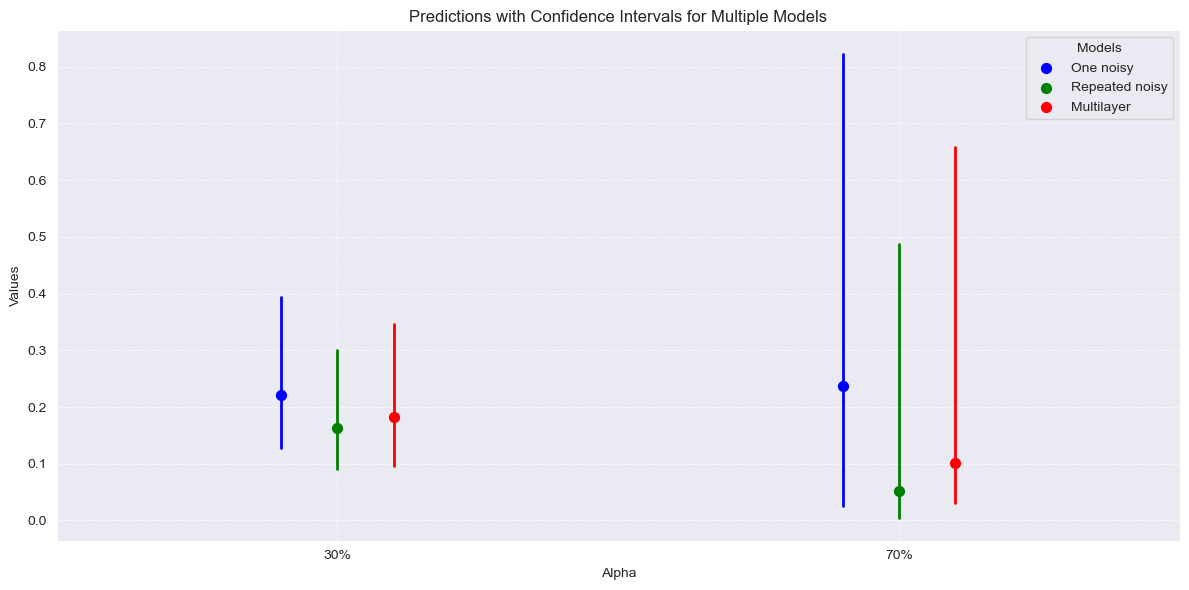

In [114]:
# plot ms results
fig, ax = plt.subplots(figsize=(12, 6))

# X-coordinates for the three variables
x = np.arange(2)
width = 0.1  # Width of each bar

# Colors for each model
colors = ['blue', 'green', 'red']
model_names = ['One noisy', 'Repeated noisy', 'Multilayer']

# Plot for each model
for i in range(3):
    # Plot the mean points
    ax.scatter(x + (i - 1) * width, combined_ms_mean_pred[i], color=colors[i], s=50, zorder=3, label=model_names[i])
    
    # Plot the confidence intervals
    for j in range(2):
        ax.plot([x[j] + (i - 1) * width, x[j] + (i - 1) * width], 
                combined_ms_quantiles_pred[i, :, j], color=colors[i], linewidth=2, zorder=2)

# Customize the plot
ax.set_xlabel('Alpha')
ax.set_ylabel('Values')
ax.set_title('Predictions with Confidence Intervals for Multiple Models')
ax.set_xticks(x)
ax.set_xticklabels(['30%', '70%'])
ax.grid(True, linestyle='--', alpha=0.7)

# Add legend
ax.legend(title='Models')

# Adjust x-axis limits for better spacing
ax.set_xlim(-0.5, len(x) - 0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [139]:
# multistage wrapped
multistage_results = wrap.multistage_run(all_data,
                                            all_stoch_trt_expos,
                                            all_post_obs_expos,
                                            all_post_stoch_expos,
                                            300,
                                            rng_key)

print(multistage_results)

Multistage run: 100%|██████████| 75/75 [00:36<00:00,  2.08it/s] 


   post_mean  post_median  post_std      q025      q975  estimand  \
0   0.229723     0.220515  0.065880  0.128750  0.390590  stoch_30   
0   0.297508     0.232684  0.227880  0.025588  0.817279  stoch_70   
0   0.171705     0.163824  0.052680  0.090588  0.299709  stoch_30   
0   0.088688     0.051691  0.115436  0.005956  0.483090  stoch_70   
0   0.191751     0.182794  0.063980  0.095441  0.343162  stoch_30   
0   0.158293     0.101066  0.152399  0.030956  0.650882  stoch_70   

            model      method  
0       one_noisy  multistage  
0       one_noisy  multistage  
0  repeated_noisy  multistage  
0  repeated_noisy  multistage  
0      multilayer  multistage  
0      multilayer  multistage  


In [107]:
# Clean data
# Remove all observations for which both the school-id and the block-number of the school are unknown (1.14% of the observations, or 280 observations)
all_schools['ID'] = pd.to_numeric(all_schools['ID'], errors='coerce').fillna(0.0)
all_schools['SCHRB'] = pd.to_numeric(all_schools['SCHRB'], errors='coerce')
# all_schools = all_schools[~all_schools['SCHRB'].isna() & (all_schools['ID'] != 999.0)]
all_schools = all_schools[~all_schools['SCHRB'].isna() &
                          (all_schools['ID'] != 999.0) & 
                          (all_schools['ID'] != 0.0) &
                          (all_schools['UID'] != 100284.0)] 

# Create unique id
all_schools['unique_id'] = all_schools['SCHID']*1000 + all_schools['ID']
all_schools['unique_id'] = all_schools['unique_id'].astype(int)

# Convert treatment variables to numeric
def extract_numeric(x):
    match = re.search(r'\(?([0-9,.]+)\)?', str(x))
    return float(match.group(1)) if match else np.nan

all_schools['TREAT_NUMERIC'] = all_schools['TREAT'].apply(extract_numeric).fillna(0.0).astype(int)
all_schools['SCHTREAT_NUMERIC'] = all_schools['SCHTREAT'].apply(extract_numeric).fillna(0.0).astype(int)
# 
# # Create indicator of eligible units
all_schools['ELIGIBLE'] = (all_schools['TREAT_NUMERIC'] != 0.0).fillna(0.0).astype(int)
# all_schools['ELIGIBLE'] = all_schools['ELIGIBLE'].fillna(0)
# 
# # Numeric version of OUTOFBLOCK
all_schools['OUTOFBLOCK_NUMERIC'] = all_schools['OUTOFBLOCK'].apply(extract_numeric).fillna(0.0).astype(int)
# 
# # Get numeric version of outcome (wearing orange band)
all_schools['WRISTOW2_NUMERIC'] = all_schools['WRISTOW2'].apply(extract_numeric).fillna(0.0).astype(int)

N_all = all_schools.shape[0]
N_elig = all_schools['ELIGIBLE'].sum()
print("N subject:" , N_all,
      "N eligible:", N_elig)

N subject: 24182 N eligible: 2943


C:\Users\bar21\AppData\Local\Temp\ipykernel_21040\1760337585.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_schools['unique_id'] = all_schools['SCHID']*1000 + all_schools['ID']
C:\Users\bar21\AppData\Local\Temp\ipykernel_21040\1760337585.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_schools['unique_id'] = all_schools['unique_id'].astype(int)
C:\Users\bar21\AppData\Local\Temp\ipykernel_21040\1760337585.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [ ]:
# Get subset of 'all_schools' with relevant columns for analysis (outcome, treatents, covariates)
df_subset = all_schools[['SCHID', 'SCHTREAT_NUMERIC', 'TREAT_NUMERIC', 'unique_id', 'ELIGIBLE', 'WRISTOW2_NUMERIC']]
# cov_list = ["GENC", "GRC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA","MOVE", "FSCH","LIVEWB", "ACTSS", "ACTT", "ACTM", "ACTR","GAME", "FLIB"]
# cov_list = ["GENC", "GRC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA", "MOVE", "ACTSS", "ACTT", "ACTM", "ACTR", "FLIB", "GAME"]
cov_list = ["GENC", "GRC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA", "ACTSS", "ACTT", "ACTM", "ACTR", "GAME"]
# cov_list = ["GENC", "GRC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA", "MOVE"]
for cov in cov_list:
    if type(all_schools[cov].iloc[1])==str:
        val = all_schools[cov].apply(extract_numeric).fillna(0.0).astype(int)
        # df_subset.loc[:,cov] = val
        df_subset = df_subset.assign(**{cov: val})
    else:
        # df_subset.loc[:,cov] = all_schools[cov]
        df_subset = df_subset.assign(**{cov: all_schools[cov]})
        
# Get dummies of 'GRC' (grade) variable
GRC_dummy = pd.get_dummies(df_subset['GRC'], drop_first=True).astype(int)
GRC_dummy.columns = ['GRC_' + str(col) for col in [6,7,8]]
df_subset = pd.concat([df_subset.drop(columns=['GRC']), GRC_dummy], axis=1)
df_subset.describe()
print(df_subset.shape)

In [ ]:
pd.crosstab(df_subset["SCHTREAT_NUMERIC"], df_subset["WRISTOW2_NUMERIC"])
# pd.crosstab(df_subset["ELIGIBLE"], df_subset["WRISTOW2_NUMERIC"])
# Almost no one in the control schools is wearing the orange band

In [ ]:
pd.crosstab(df_subset["SCHTREAT_NUMERIC"], df_subset["ELIGIBLE"])


In [ ]:
pd.crosstab(df_subset["TREAT_NUMERIC"], df_subset["ELIGIBLE"])

In [ ]:
all_schools['SCHID'].value_counts().describe()

In [ ]:
all_schools['SCHTREAT_NUMERIC'].value_counts()


In [ ]:
len(np.unique(all_schools[all_schools['SCHTREAT_NUMERIC']==1.0]['SCHID']))

In [ ]:
all_schools[all_schools['SCHTREAT_NUMERIC']==0.0].groupby('SCHID')['TREAT_NUMERIC'].value_counts()
# all_schools[all_schools['SCHTREAT_NUMERIC']==1.0].groupby('SCHID')['WRISTOW2_NUMERIC'].value_counts()

In [ ]:
school_treat = all_schools[['SCHID', 'SCHTREAT_NUMERIC']].groupby('SCHID').agg({'SCHTREAT_NUMERIC': ['mean', 'count']}).reset_index()
school_treat

In [ ]:
def network_by_school(df: np.ndarray, school_id: float | int , cols: list[str]) -> np.ndarray:
    # Save subset of df
    # school_df = df[df['SCHID'] == school_id]
    school_mask = df['SCHID'] == school_id
    school_df = df[school_mask].copy()  # Create a copy to avoid warnings
    school_df['unique_id'] = (school_df['SCHID']*1000 + school_df['ID']).astype(int)
    # school_df['unique_id'] = school_df['unique_id'].astype(int)
    # Replace 999 with NaN as 999 is the code for missing values
    for col in cols:
        row_mask = school_df[col] == 999
        # school_df[col][row_mask] = np.nan
        school_df.loc[row_mask,col] = np.nan
        # school_df[col][school_df[col] == 999] = np.nan
    # Add SCHID * 1000 to survey data (to obtain edge list with `unique_id` values)  
    for col in cols:
        school_df[col] += school_df['SCHID'] * 1000
    # Save edgelists
    school_edgelist = []
    for col in cols:
        school_edgelist.extend(zip(school_df['unique_id'], school_df[col]))
        
    valid_ids = set(school_df['unique_id'])
    school_edgelist = [
        (int(a), int(b)) 
        for a, b in school_edgelist 
        if not np.isnan(a) and not np.isnan(b) 
        and int(a) in valid_ids and int(b) in valid_ids
        and int(a) != int(b)
    ]
    # Add selfloops
    for id in valid_ids:
        school_edgelist.append((id, id))
    # Convert to nx graph
    school_network = nx.Graph(school_edgelist)
    # remove self loops
    school_network.remove_edges_from(nx.selfloop_edges(school_network))
    
    nx.draw_circular(school_network, 
            node_color = school_df['TREAT_NUMERIC'],
            node_size=[school_network.degree(node) + 1 for node in school_network.nodes()],
            width=0.15)

    
    # return adj. matrix
    return nx.to_numpy_array(school_network)


In [ ]:
ST_cols = ['ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7', 'ST8', 'ST9', 'ST10']
ST_W2_cols = ['ST1W2', 'ST2W2', 'ST3W2', 'ST4W2', 'ST5W2', 'ST6W2', 'ST7W2', 'ST8W2', 'ST9W2', 'ST10W2']
BF_cols = ['BF1', 'BF2']
tst_net = network_by_school(all_schools, school_treat.iloc[0,0], ST_cols)
tst_new_W2 = network_by_school(all_schools, school_treat.iloc[0,0], ST_W2_cols)
tst_new_BF = network_by_school(all_schools, school_treat.iloc[0,0], BF_cols)

print(tst_net.shape, school_treat.iloc[0,2], type(tst_net))
print(tst_new_W2.shape, school_treat.iloc[0,2], type(tst_new_W2))
print(tst_new_BF.shape, school_treat.iloc[0,2], type(tst_new_BF))
eig_cen = aux.eigen_centrality(tst_net)
print(np.mean(eig_cen), np.min(eig_cen), np.max(eig_cen), np.median(eig_cen))

trts = jnp.array((all_schools[all_schools['SCHID'] == school_treat.iloc[0,0]]['TREAT_NUMERIC']==1).astype(int))
cntrl = jnp.array((all_schools[all_schools['SCHID'] == school_treat.iloc[0,0]]['TREAT_NUMERIC']==2).astype(int))
print(trts.shape, trts.mean())
print(cntrl.shape, cntrl.mean())
zeigen = aux.zeigen_value(trts, eig_cen , tst_net)
print("Zeigen:", np.mean(zeigen), np.min(zeigen), np.max(zeigen), np.median(zeigen))
zeigen_standratized = (aux.zeigen_value(trts, eig_cen , tst_net)) / (jnp.dot(tst_net, eig_cen)+1)
print("Zegien / sum_eigcen:", np.mean(zeigen_standratized), np.min(zeigen_standratized), np.max(zeigen_standratized), np.median(zeigen_standratized))
n_trts = jnp.dot(tst_net, trts) 
print(np.mean(n_trts), np.min(n_trts), np.max(n_trts), np.median(n_trts), np.std(n_trts))
n_cntrl = jnp.dot(tst_net, cntrl)
print(np.mean(n_cntrl), np.min(n_cntrl), np.max(n_cntrl), np.median(n_cntrl), np.std(n_cntrl))
# plt.hist(np.sum(tst_net, 1), bins=30)

In [ ]:
plt.hist(n_trts , bins=30)
print(np.mean(n_trts>0), np.mean(n_cntrl>0), np.mean(((n_trts > 0) | (n_cntrl > 0))))
# plt.scatter(zeigen, np.dot(tst_net, trts), c=trts)
# plt.scatter(n_trts[n_trts>0], zeigen_standratized[n_trts>0], c=trts[n_trts>0])
# plt.scatter(zeigen, zeigen_standratized, c=trts)

In [ ]:
tab_df = pd.DataFrame({'n_trt': n_trts>0, 'zeig': zeigen >0})
pd.crosstab(tab_df['n_trt'], tab_df['zeig'])

In [ ]:
# Get df for network analysis
# generate covariates as indicator of equality in unit-level covariates: X_ij = I(X_i = X_j)

school_mask = df_subset['SCHID'] == school_treat.iloc[0,0]
school_df = df_subset[school_mask].copy()  # Create a copy to avoid warnings

idx_pairs = list(combinations(range(school_df.shape[0]), 2))

def cov_equal(X: pd.DataFrame, idx_pairs: list) -> list[int]:
    return [int(np.all(X.iloc[i] == X.iloc[j])) for i, j in idx_pairs]

def create_net_covar_df(df: pd.DataFrame, cov_groups: list) -> pd.DataFrame:
    idx_pairs = list(combinations(range(df.shape[0]), 2))
    cov_eq = [cov_equal(df[cov], idx_pairs) for cov in cov_groups]
    df_network = pd.DataFrame(dict(zip(['+'.join(cov) for cov in cov_groups], cov_eq)))
   
    expected_rows = df.shape[0] * (df.shape[0] - 1) // 2
    assert df_network.shape[0] == expected_rows, f"Expected {expected_rows} rows, got {df_network.shape[0]}"
    
    return df_network
    
cov_for_network = [["GENC"],
                   ["ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA"],
                   # ["ACTSS", "ACTT", "ACTM", "ACTR"],
                   ["GAME"],
                   ["GRC_6", "GRC_7", "GRC_8"]]
# cov_eq = [cov_equal(school_df[cov], idx_pairs) for cov in cov_for_network]
# df_for_network = pd.DataFrame(cov_eq).T
# df_for_network.columns = ["GENC", "ETH", "MOVE", "FSCH", "LIVEWB", "ACT", "GAME", "FLIB", "GRC"]
df_for_network = create_net_covar_df(school_df, cov_for_network)

print(school_df.shape[0]*(school_df.shape[0]-1)/2, df_for_network.shape[0])
print(df_for_network.describe())
    

In [ ]:
print(jnp.array(df_for_network).shape, jnp.array(df_for_network).sum(axis=1).mean())

In [ ]:
# # adj mat to triu vals
# @jit
# def adj_to_triu(mat: np.ndarray) -> jnp.ndarray:
#     return jnp.array(mat[np.triu_indices(mat.shape[0], k=1)])

def adj_to_triu(mat: np.ndarray) -> np.ndarray:
    return mat[np.triu_indices(mat.shape[0], k=1)]

triu_sch = adj_to_triu(tst_net)
print(triu_sch.shape, triu_sch.sum(), tst_net.sum()/2, type(triu_sch))


In [ ]:
print(jnp.array([adj_to_triu(tst_net), adj_to_triu(tst_new_W2)]).shape)
print(jnp.array([adj_to_triu(tst_net), adj_to_triu(tst_new_W2)])[0,:].shape)
print(jnp.array([adj_to_triu(tst_net), adj_to_triu(tst_new_W2)])[1,:].shape)
print(jnp.array([adj_to_triu(tst_net), adj_to_triu(tst_new_W2)]).ndim)
print(jnp.array(adj_to_triu(tst_net)).ndim)
print(jnp.array(adj_to_triu(tst_net)).shape)

In [ ]:
print(jnp.array(df_for_network).shape)
print(jnp.dot(jnp.array(df_for_network),jnp.ones(4)).shape)


In [ ]:
torch.from_numpy(adj_to_triu(tst_net)).shape

In [ ]:
torch.tensor(np.array(df_for_network)).shape[1]


In [ ]:
tst_ST_triu = torch.tensor(adj_to_triu(tst_net),dtype=torch.float32)
tst_STW2_triu = torch.tensor(adj_to_triu(tst_new_W2),dtype=torch.float32)
tst_BF_triu = torch.tensor(adj_to_triu(tst_new_BF),dtype=torch.float32)

In [79]:
rng_key = random.PRNGKey(1)
rng_key, rng_key_ = random.split(rng_key)

school_svi_tst = util.Network_SVI(x_df = torch.tensor(np.array(df_for_network), dtype=torch.float32), 
                                  # triu_obs = torch.tensor(adj_to_triu(tst_net),dtype=torch.float32))
                                  triu_obs = torch.stack([tst_ST_triu, tst_STW2_triu]),
                                  # triu_obs = torch.stack([tst_ST_triu, tst_BF_triu]),
                                  # network_model=models.multilayer_networks_model)
                                  network_model=models.repeated_noisy_networks_model,
                                  n_iter = 1000,
                                  n_samples = 1000)

school_svi_tst.train_model()

[autoreload of wrapper_functions failed: Traceback (most recent call last):
  File "C:\Users\bar21\.conda\envs\STAT\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
    
  File "C:\Users\bar21\.conda\envs\STAT\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
    
  File "C:\Users\bar21\.conda\envs\STAT\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
    
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "C:\Users\bar21\Dropbox\My PC (LAPTOP-6NAJD2IQ)\Desktop\Gate\University\TAU\PhD\Writing\Drafts\Sampled networks\Ba

NameError: name 'df_for_network' is not defined

In [ ]:
school_posterior_samps_svi = school_svi_tst.network_samples()

In [ ]:
school_posterior_samps_svi.shape

In [ ]:
school_triu_obs_pred = school_svi_tst.sample_triu_obs_predictive(num_samples = 10000)
school_triu_obs_pred.shape

In [ ]:
school_triu_obs_pred[0,0].shape

In [ ]:
school_triu_obs_pred.std(axis=0)

In [ ]:
def triu_to_mat(triu_values, N):
    """
    Convert upper triangular values to a full adjacency matrix.
    
    Parameters:
    triu_values (torch.Tensor): Upper triangular values, shape (num_triu_elements,)
    N (int): Number of nodes in the network
    
    Returns:
    torch.Tensor: Full adjacency matrix, shape (N, N)
    """
    # Create an empty N x N matrix
    adj_matrix = torch.zeros((N, N), dtype=triu_values.dtype)
    
    # Get the indices for the upper triangular part
    triu_indices = torch.triu_indices(N, N, offset=1)
    
    # Fill the upper triangular part
    adj_matrix[triu_indices[0], triu_indices[1]] = triu_values
    
    # Make the matrix symmetric by adding its transpose
    adj_matrix = adj_matrix + adj_matrix.T
    
    return adj_matrix

N_units = school_df.shape[0]

degs_post = torch.zeros(N_units, dtype=school_triu_obs_pred.dtype)
degs_post2 = torch.zeros(N_units, dtype=school_triu_obs_pred.dtype)
deg_post_star = torch.zeros(N_units, dtype=school_triu_obs_pred.dtype)

for i in tqdm(range(10000)):
    mat_i = triu_to_mat(school_triu_obs_pred[0,i], N_units)
    mat_i2 = triu_to_mat(school_triu_obs_pred[1,i], N_units)
    cur_deg = mat_i.sum(axis=1)
    cur_deg2 = mat_i2.sum(axis=1)
    degs_post += cur_deg
    degs_post2 += cur_deg2
    star_mat_i = triu_to_mat(torch.from_numpy(np.array(school_posterior_samps_svi[i])), N_units)
    deg_post_star += star_mat_i.sum(axis=1)

degs_post /= 10000
degs_post2 /= 10000
deg_post_star /= 10000

# obs_deg = torch.tensor((tst_new_W2.sum(axis=1) + tst_net.sum(axis=1))/2, dtype=deg_post_star.dtype)
obs_deg = torch.tensor(tst_net.sum(axis=1), dtype=deg_post_star.dtype)
obs_deg2 = torch.tensor(tst_new_BF.sum(axis=1), dtype=deg_post_star.dtype)

# print("MAE:", torch.mean(torch.abs((obs_deg - degs_post))))

# plt.figure(figsize=(4,3))
# plt.scatter(obs_deg, degs_post)
# x axis label = "Observed degree"
# y axis label = "Posterior predictive degree"
# plt.xlabel("Observed degree")
# plt.ylabel("Posterior predictive degree")
# plt.axline((0, 0), slope=1, color="orange", linestyle="--")   
    

In [ ]:
# plt.figure(figsize=(4,3))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# plt.scatter(obs_deg, deg_post_star)
ax1.scatter(obs_deg, degs_post)
ax1.axline((0, 0), slope=1, color="orange", linestyle="--")
ax2.scatter(obs_deg2, degs_post2)
ax2.axline((0, 0), slope=1, color="orange", linestyle="--")
# x axis label = "Observed degree"
# y axis label = "Posterior predictive degree"
# plt.xlabel("Observed degree")
# plt.ylabel("Posterior star degree")
# plt.axline((0, 0), slope=1, color="orange", linestyle="--")  

In [ ]:
plt.figure(figsize=(4,3))
plt.scatter(obs_deg, deg_post_star)
plt.axline((0, 0), slope=1, color="orange", linestyle="--")

In [ ]:
# TODO: Think the outcome analysis should be limited to the eligible students only (due to positivity)
# TODO: think about estimands. Good options is to take stochastic estimands with different alphas (e.g., alpha = 0.3,0.5,0.7) vs baseline of treating no one
# TODO: limit outcome analysis for only students in SCHTREAT == 1 as other schools are not given the outcome.
# Nonetheless, the network analysis should be done on the full network of each school (avoid network sampling)


In [ ]:

def group_indicators_to_indices(df):
    """
    Convert a DataFrame of binary group indicators to a vector of indices.
    Parameters:
    df (pandas.DataFrame): N x K DataFrame of binary indicators.
                           Each row should sum to 1.
    Returns:
    numpy.ndarray: N-length vector of indices in the range [0, K-1]
    """
    # Check if each row sums to 1
    if not (df.sum(axis=1) == 1).all():
        raise ValueError("Each row in the DataFrame must sum to 1")
    
    indices = jnp.argmax(df.values, axis=1)
    
    return indices

In [ ]:
school_df_eligibles = school_df[school_df['ELIGIBLE']==1]
print(school_df.shape, school_df_eligibles.shape)
tst_grades = group_indicators_to_indices(school_df_eligibles[['GRC_6', 'GRC_7', 'GRC_8']])
print(len(np.unique(tst_grades)), tst_grades.shape, type(tst_grades))

In [ ]:
# school_df['SCHID'].values - 1
fixed_df = jnp.array(school_df_eligibles[["GENC", "ETHW", "ETHH", "GAME"]].values)
# fixed_df = school_df_eligibles[["GENC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "GAME"]].values
# all_trts = jnp.array(school_df['TREAT_NUMERIC'].values - 1)
all_trts = jnp.array(school_df['TREAT_NUMERIC'].values==2, dtype=int)
# obs_trts = jnp.array(school_df_eligibles['TREAT_NUMERIC'].values - 1)
obs_trts = jnp.array(school_df_eligibles['TREAT_NUMERIC'].values==2, dtype=int)
obs_outcome = jnp.array(school_df_eligibles['WRISTOW2_NUMERIC'].values)
sch_trt = jnp.array(school_df_eligibles['SCHTREAT_NUMERIC'].values)
tst_school = jnp.array(school_df_eligibles['SCHID'].values - 1, dtype=int)

exposures_all = util.zeigen_value(Z=all_trts, adj_mat=tst_net)
exposures_elig = exposures_all[(school_df['ELIGIBLE']==1).values]
# exposure_elig_sub = util.zeigen_value(Z=all_trts, adj_mat=tst_net, subset = (school_df['ELIGIBLE']==1).values)
print(len(exposures_all), len(exposures_elig))
print(fixed_df.shape, '\n', obs_trts.shape, '\n', obs_outcome.shape, '\n', sch_trt.shape,
      '\n', tst_school.shape, '\n', tst_grades.shape, '\n', exposures_elig.shape)

obs_data = {'X' : fixed_df, 'school' : tst_school,  'grade' : tst_grades,
            'trts' : obs_trts, 'sch_trts' : sch_trt ,
             'exposures' : exposures_elig, 'Y' : obs_outcome}

In [ ]:
print(len(jnp.unique(obs_data['school'])), len(jnp.unique(obs_data['grade'])))

In [ ]:
# Outcome model with observed network
rng_key = random.PRNGKey(0)
_, rng_key = random.split(rng_key)

outcome_obs = util.Outcome_MCMC(data=obs_data, rng_key=rng_key)


In [ ]:
# stoch_30 = util.stochastic_intervention(alpha=0.3, n=len(sch_trt))
stoch_30 = util.stochastic_intervention(alpha=0.3, n=school_df.shape[0])
exposures_stoch_30 = util.zeigen_value(Z=stoch_30, adj_mat=tst_net)
print(exposures_stoch_30.shape, stoch_30.shape)
stoch_30_elig = exposures_stoch_30[:,(school_df['ELIGIBLE']==1).values]
exposures_stoch_30_elig = exposures_stoch_30[:,(school_df['ELIGIBLE']==1).values]
stoch_70 = util.stochastic_intervention(alpha=0.7, n=school_df.shape[0])
stoch_70_elig = stoch_70[:,(school_df['ELIGIBLE']==1).values]
exposures_stoch_70 = util.zeigen_value(Z=stoch_70, adj_mat=tst_net)
exposures_stoch_70_elig = exposures_stoch_70[:,(school_df['ELIGIBLE']==1).values]
print(exposures_stoch_70.shape, stoch_70.shape, stoch_70_elig.shape, exposures_stoch_70_elig.shape)
print(exposures_stoch_30.shape, stoch_30.shape, stoch_30_elig.shape, exposures_stoch_30_elig.shape)

In [ ]:
pred_stoch_30 = outcome_obs.get_predicted_values(trts = stoch_30_elig, exposures = exposures_stoch_30_elig)
print(pred_stoch_30.shape)
pred_stoch_70 = outcome_obs.get_predicted_values(trts = stoch_70_elig, exposures = exposures_stoch_70_elig)
print(pred_stoch_70.shape)

In [ ]:
post_esti =  jnp.mean(pred_stoch_70, axis=1) - jnp.mean(pred_stoch_30, axis=1)
print("mean esti [95% CI]:", jnp.mean(post_esti), jnp.percentile(post_esti, 2.5), jnp.percentile(post_esti, 97.5))

plt.figure(figsize=(4,3))
plt.hist(post_esti, bins=30, color='skyblue', density = True)


In [ ]:
post_obs_exposure = util.vectorized_post_exposures(school_posterior_samps_svi[0:1000], all_trts, all_trts.shape[0])
print(post_obs_exposure.shape)
post_obs_expos_elig = post_obs_exposure[:,(school_df['ELIGIBLE']==1).values]
print(post_obs_expos_elig.shape)

In [ ]:
plt.figure(figsize=(4,3))
# plt.scatter(post_obs_exposure.mean(axis=0), exposures_all)
plt.scatter(post_obs_expos_elig.mean(axis=0), exposures_elig)
plt.axline((0, 0), slope=1, color="orange", linestyle="--")

In [ ]:
# Run onestage
onestage_tst = util.Onestage_MCMC(obs_trts=obs_trts, post_exposures=post_obs_expos_elig.mean(axis=0), sch_trts=sch_trt, 
                                  fixed_df = fixed_df, grade = tst_grades, school=tst_school, Y=obs_outcome, rng_key=rng_key)


In [ ]:
pred_stoch_30_OS = onestage_tst.get_predicted_values(stoch_30_elig, exposures_stoch_30_elig)
print(pred_stoch_30_OS.shape)
pred_stoch_70_OS = onestage_tst.get_predicted_values(stoch_70_elig, exposures_stoch_70_elig)
print(pred_stoch_70_OS.shape)

In [ ]:
post_esti_OS =  jnp.mean(pred_stoch_70_OS, axis=1) - jnp.mean(pred_stoch_30_OS, axis=1)
print("mean esti [95% CI]:", jnp.mean(post_esti_OS), jnp.percentile(post_esti_OS, 2.5), jnp.percentile(post_esti_OS, 97.5))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.hist(post_esti, bins=30, color='skyblue', density = True)
ax2.hist(post_esti_OS, bins=30, color='skyblue', density = True)

plt.show()


In [78]:
post_a30_exposure = util.vectorized_post_exposures(school_posterior_samps_svi[0:1000], stoch_30, all_trts.shape[0])
print(post_a30_exposure.shape)
post_a30_exposure_elig = post_a30_exposure[:,:, (school_df['ELIGIBLE'] == 1).values]
print(post_a30_exposure_elig.shape)

post_a70_exposure = util.vectorized_post_exposures(school_posterior_samps_svi[0:1000], stoch_70, all_trts.shape[0])
print(post_a70_exposure.shape)
post_a70_exposure_elig = post_a70_exposure[:,:, (school_df['ELIGIBLE'] == 1).values]
print(post_a70_exposure_elig.shape)

NameError: name 'school_posterior_samps_svi' is not defined

In [ ]:
post_stoch_exposures = jnp.transpose(jnp.stack([post_a30_exposure_elig, post_a70_exposure_elig]),axes=(1,0,2,3))
print(post_stoch_exposures.shape)
stoch_trt_all = jnp.stack([stoch_30_elig, stoch_70_elig])
print(stoch_trt_all.shape)

In [ ]:
print(post_stoch_exposures[0:4].shape)
print(post_obs_expos_elig[0:4].shape)

In [ ]:
# TODO: debug multistage inference 
# TODO: write function that wrap evertything: network sampling and posterior for each school (seperately), join the data for outcome regressions, and predictions of estimands

In [ ]:
# Run multistage
multistage_tst = util.linear_multistage(post_exposures=post_obs_expos_elig, post_new_expsoures=post_stoch_exposures,
                                        obs_trts=obs_trts, new_trts=stoch_trt_all, sch_trts=sch_trt,
                                        fixed_df=fixed_df, grade=tst_grades, school=tst_school, Y=obs_outcome, key=rng_key)

In [ ]:
print(multistage_tst.shape, multistage_tst[0].shape)

In [ ]:
post_esti_MS =  jnp.mean(multistage_tst[1], axis=1) - jnp.mean(multistage_tst[0], axis=1)
print(post_esti_MS.shape)
print("mean esti [95% CI]:", jnp.mean(post_esti_MS), jnp.percentile(post_esti_MS, 2.5), jnp.percentile(post_esti_MS, 97.5))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

ax1.hist(post_esti, bins=30, color='skyblue', density = True)
ax2.hist(post_esti_OS, bins=30, color='darkgreen', density = True)
ax3.hist(post_esti_MS, bins=30, color='darkorange', density = True)

plt.show()